In [12]:
# importing required libraries
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, LSTM, RNN, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model

In [2]:
CLASS_DESCRIPTION = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}

In [3]:
# Images from the train folder will be used to train, validate and test the models
IMG_PATH = '../Data/train/'
img_list = []
img_labels = []
for file in glob.glob(IMG_PATH+'*/*.jpg'):
    label = file.split("/")[3]
    img_labels.append(label)
    img_array = cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB)
    img_list.append(img_array)

In [4]:
# Checking Number of Images and Labels read
print(f"Number of Images Read: {len(img_list)}")
print(f"Number of Labels Read: {len(img_labels)}")

Number of Images Read: 22424
Number of Labels Read: 22424


In [5]:
dict(Counter(img_labels))

{'c7': 2002,
 'c0': 2489,
 'c9': 2129,
 'c8': 1911,
 'c1': 2267,
 'c6': 2325,
 'c3': 2346,
 'c4': 2326,
 'c5': 2312,
 'c2': 2317}

In [6]:
# Printing Number of Images per each class
img_dict = {}
for label in img_labels:
    if label in img_dict:
        img_dict[label]+=1
    else:
        img_dict[label]=1
labels = list(img_dict.keys())
labels.sort()
for label in labels:
    print(f"No of images in {label} : {img_dict[label]}")

No of images in c0 : 2489
No of images in c1 : 2267
No of images in c2 : 2317
No of images in c3 : 2346
No of images in c4 : 2326
No of images in c5 : 2312
No of images in c6 : 2325
No of images in c7 : 2002
No of images in c8 : 1911
No of images in c9 : 2129


In [7]:
# Resizing images by 25 percent and also creating greyscale images
rgb_imgs_list = []
bw_img_list = []

for img in img_list:
    resized_img = cv.resize(img, (int(img.shape[1] * 0.25), int(img.shape[0] * 0.25)))
    bw_img = cv.cvtColor(resized_img, cv.COLOR_RGB2GRAY)
    bw_img_list.append(bw_img)
    rgb_imgs_list.append(resized_img)

In [8]:
# Creating a label dataframe to split Train Test Data for labels
labels_df = pd.DataFrame(img_labels, columns=['label'])

# Resetting the index so that the index number will be used to fetch the associated image from the image list
labels_df = labels_df.reset_index()

# Encoding image labels to numericals for classification
labels_df["encoded_label"] = labels_df['label'].apply(lambda x: int(x[1]))

display(labels_df.head())
print(f"Labels Dataframe Shape: {labels_df.shape}")

,index,label,encoded_label
0,0,c7,7
1,1,c7,7
2,2,c7,7
3,3,c7,7
4,4,c7,7


Labels Dataframe Shape: (22424, 3)


In [9]:
# Splitting the data to create 20% of test data from the available data
train_val_df, test_df = train_test_split(labels_df, test_size=0.2, random_state = 1234)

# Splitting the train and validation data 
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state = 1234)

In [10]:
# Checking the number of images for each class across train, validation and test data
train_df_label_counts = pd.DataFrame(train_df['label'].value_counts()).reset_index()
train_df_label_counts.columns = ['label', 'train_data_label_counts']

val_df_label_counts = pd.DataFrame(val_df['label'].value_counts()).reset_index()
val_df_label_counts.columns = ['label', 'val_data_label_counts']

test_df_label_counts = pd.DataFrame(test_df['label'].value_counts()).reset_index()
test_df_label_counts.columns = ['label', 'test_data_label_counts']

label_counts_df = train_df_label_counts.merge(val_df_label_counts, on='label')
label_counts_df = label_counts_df.merge(test_df_label_counts, on='label')
label_counts_df.sort_values(by=['label'])

,label,train_data_label_counts,val_data_label_counts,test_data_label_counts
0,c0,1613,375,501
5,c1,1440,371,456
3,c2,1496,348,473
2,c3,1500,377,469
1,c4,1505,362,459
6,c5,1436,398,478
4,c6,1489,375,461
8,c7,1258,350,394
9,c8,1242,298,371
7,c9,1372,334,423


In [11]:
# Creating the train, validation and test data sets for the images and labels using the 
# Label Train, validation and Test split dataframes.

# Lists to hold greyscale Images
bw_train_img_list = []
bw_val_img_list = []
bw_test_img_list = []

# Lists to hold RGB Images
rgb_train_img_list = []
rgb_val_img_list = []
rgb_test_img_list = []


# Lists to hold the Labels
train_labels_list = []
val_labels_list =[]
test_labels_list = []


for row in train_df.iterrows():
    train_label = row[1]['encoded_label']
    train_index = row[1]['index']
    train_labels_list.append(train_label)
    bw_train_img_list.append(bw_img_list[train_index])
    rgb_train_img_list.append(rgb_imgs_list[train_index])

for row in val_df.iterrows():
    val_label = row[1]['encoded_label']
    val_index = row[1]['index']
    val_labels_list.append(val_label)
    bw_val_img_list.append(bw_img_list[val_index])
    rgb_val_img_list.append(rgb_imgs_list[val_index])
    
for row in test_df.iterrows():
    test_label = row[1]['encoded_label']
    test_index = row[1]['index']
    test_labels_list.append(test_label)
    bw_test_img_list.append(bw_img_list[test_index])
    rgb_test_img_list.append(rgb_imgs_list[test_index])



In [13]:
vgg_model_path = '../Results/vgg_model.keras'
vgg_model = load_model(vgg_model_path)

2024-04-04 19:13:45.379113: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-04 19:13:45.379167: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-04-04 19:13:45.379170: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-04-04 19:13:45.379258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-04 19:13:45.379295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
vgg_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 40, 128)       0     

In [16]:
vgg_model.input

<KerasTensor: shape=(None, 120, 160, 3) dtype=float32 (created by layer 'input_3')>

In [23]:
rgb_train_img_list[1].resize(1,120,160,3)

In [24]:
rgb_train_img_list[1].shape

(1, 120, 160, 3)

In [40]:
layer_names = ['block1_conv1', 'block1_pool', 'block2_conv1', 'block5_conv1', 'block5_conv3', 'block5_pool']

# Create a model to output feature maps
layer_outputs = [vgg_model.get_layer(name).output for name in layer_names]
feature_map_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=layer_outputs)

# Example input data (update according to your model's input shape)
input_data = rgb_train_img_list[1]

# Predict and extract the feature maps
feature_maps = feature_map_model.predict(input_data)

1/1 [==============================] - 0s 78ms/step


In [37]:
feature_maps[1].shape[-1]

128

Layer: block1_conv1 | Feature map shape: (1, 120, 160, 64)


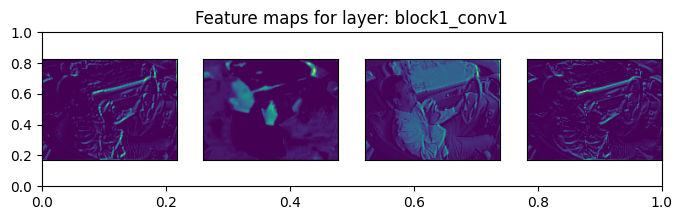

Layer: block1_pool | Feature map shape: (1, 60, 80, 64)


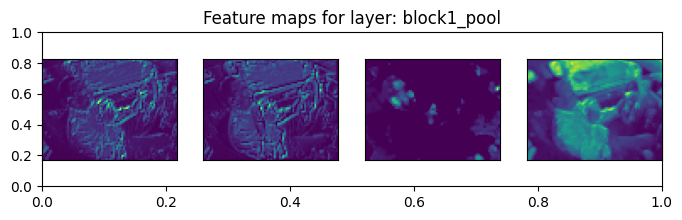

Layer: block2_conv1 | Feature map shape: (1, 60, 80, 128)


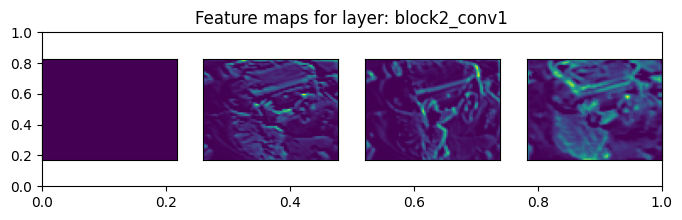

Layer: block5_conv1 | Feature map shape: (1, 7, 10, 512)


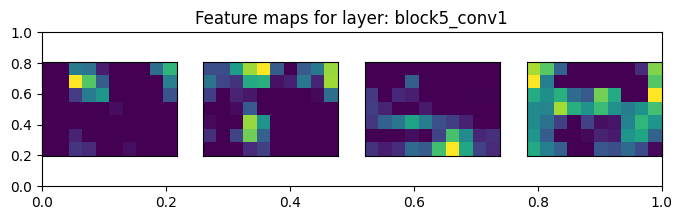

Layer: block5_conv3 | Feature map shape: (1, 7, 10, 512)


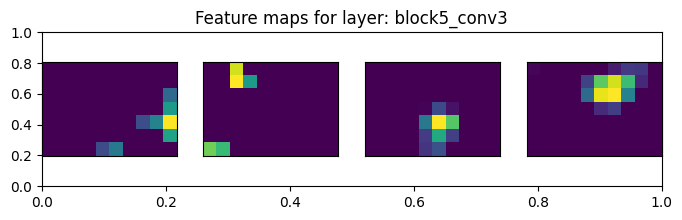

Layer: block5_pool | Feature map shape: (1, 3, 5, 512)


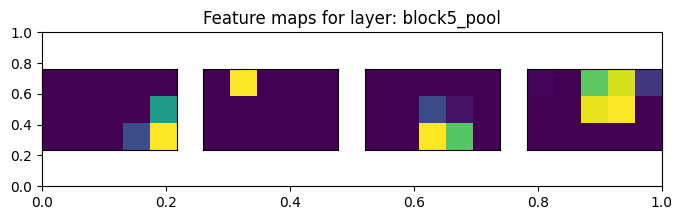

In [41]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"Layer: {layer_name} | Feature map shape: {feature_map.shape}")
    
    # Set the number of features you want to display for each layer
    n_features = 4
    size = feature_map.shape[1]  
    
    # Define the number of columns for the display
    n_cols = 4
    n_rows = n_features // n_cols
    
    # Set up the matplotlib figure
    fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))
    plt.title(f"Feature maps for layer: {layer_name}")
    
    # Loop over all the features
    for i in range(1, n_features + 1):
        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Display the i-th feature map
        plt.imshow(feature_map[0, :, :, i - 1], cmap='viridis')
    
    plt.show()

In [ ]:
vgg_model_path = '../Results/vgg_model.keras'
vgg_model = load_model(vgg_model_path)
vgg_model.summary()